<a href="https://colab.research.google.com/github/pal-ette/iNotePal/blob/7-short/%EB%8B%A8%EB%B0%9C%EC%84%B1%EB%8C%80%ED%99%94%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [29]:
root = '/content/drive/MyDrive/iNotePal/단발성대화데이터셋'

In [30]:
df = pd.read_excel(os.path.join(root, 'short_conversation.xlsx'), usecols=['Sentence', 'Emotion'])

In [31]:
df.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [5]:
df['Emotion'].unique()

array(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype=object)

In [8]:
emotion = df.groupby(['Emotion']).count()

In [14]:
emotion.index

Index(['공포', '놀람', '분노', '슬픔', '중립', '행복', '혐오'], dtype='object', name='Emotion')

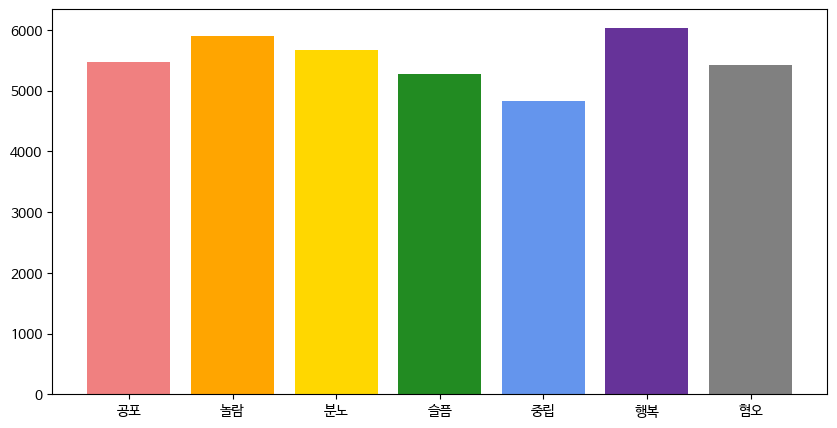

In [18]:
plt.rc('font', family='NanumBarunGothic')
colors = ['lightcoral', 'orange', 'gold', 'forestgreen', 'cornflowerblue', 'rebeccapurple', 'gray']

plt.figure(figsize=(10, 5))
plt.bar(emotion.index, emotion['Sentence'], color=colors)
# plt.legend(cmap)

plt.show()